# Structured State Space sequence model (S4) SIR Model Proof of Concept

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import pandas as pd
import numpy as np

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from models.s4.s4 import S4Block as S4  # Can use full version instead of minimal S4D standalone below
from models.s4.s4d import S4D
from tqdm.auto import tqdm

# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [2]:
class Args(argparse.Namespace):
    lr = 0.01
    weight_decay = 0.01
    epochs = 50
    dataset = 'sir'
    num_workers = 4
    batch_size = 5
    n_layers = 2
    d_model = 8
    dropout = 0.1
    resume = False
    prenorm = False

args=Args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print(f'==> Preparing {args.dataset} data..')

def split_train_val(train, val_split):
    train_len = int(len(train) * (1.0-val_split))
    train, val = torch.utils.data.random_split(
        train,
        (train_len, len(train) - train_len),
        generator=torch.Generator().manual_seed(42),
    )
    return train, val

==> Preparing sir data..


In [3]:
class SIRDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.df = pd.read_csv(path)
        self.i = self.df.iloc[:,0]
        self.states = self.df.iloc[:,1:]
        self.states.iloc[:,0:3] = self.states.iloc[:,0:3] / 100_000
        self.seq_len = 10
    
    def __len__(self):
        return len(self.df) - self.seq_len
    
    def __getitem__(self, idx):
        begin = idx
        end = idx + self.seq_len
        i_seq = np.array(self.i.iloc[begin:end]).astype(np.float32)
        t = np.ones(len(i_seq)) * begin
        t = t.astype(np.float32)
        
        i = torch.from_numpy(np.stack([i_seq, t]))
        state = torch.from_numpy(np.array(self.states.iloc[begin]).astype(np.float32))
        
        return i, state
     

In [4]:
if args.dataset == 'sir':

    trainset = SIRDataset('./data/sir_example_data.csv')
    valset = trainset
    testset = trainset
    d_input = 2
    d_output = 4

# Dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

/var/tmp/ipykernel_5709/3902178299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.states.iloc[:,0:3] = self.states.iloc[:,0:3] / 100_000


In [5]:
class S4Model(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
    ):
        super().__init__()

        self.prenorm = prenorm

        # Linear encoder (d_input = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(d_input, d_model)

        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, args.lr))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))

        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = x.transpose(-1,0)
        x = x.transpose(-1,-2)
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)

            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)

            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Pooling: average pooling over the sequence length
        x = x.mean(dim=1)

        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x

In [6]:
# Model
best_loss = -np.inf  # best test accuracy

print('==> Building model..')
model = S4Model(
    d_input=d_input,
    d_output=d_output,
    d_model=args.d_model,
    n_layers=args.n_layers,
    dropout=args.dropout,
    prenorm=args.prenorm,
)

model = model.to(device)
if device == 'cuda':
    cudnn.benchmark = True

if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

def setup_optimizer(model, lr, weight_decay, epochs):
    """
    S4 requires a specific optimizer setup.

    The S4 layer (A, B, C, dt) parameters typically
    require a smaller learning rate (typically 0.001), with no weight decay.

    The rest of the model can be trained with a higher learning rate (e.g. 0.004, 0.01)
    and weight decay (if desired).
    """

    # All parameters in the model
    all_parameters = list(model.parameters())

    # General parameters don't contain the special _optim key
    params = [p for p in all_parameters if not hasattr(p, "_optim")]

    # Create an optimizer with the general parameters
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)

    # Add parameters with special hyperparameters
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    # Create a lr scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Print optimizer info
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer, scheduler = setup_optimizer(
    model, lr=args.lr, weight_decay=args.weight_decay, epochs=args.epochs
)

###############################################################################
# Everything after this point is standard PyTorch training!
###############################################################################

# Training
def train():
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets= inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.T)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # _, predicted = outputs.max(1)
        # total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()

        pbar.set_description(
            'Batch Idx: (%d/%d) | Loss: %.3f' %
            (batch_idx, len(trainloader), train_loss/(batch_idx+1))
        )


def eval(epoch, dataloader, checkpoint=False):
    global best_loss
    model.eval()
    eval_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader))
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets= inputs.to(device), targets.to(device)
            outputs = model(inputs.T)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            # _, predicted = outputs.max(1)
            # total += targets.size(0)
            # correct += predicted.eq(targets).sum().item()

            # pbar.set_description(
            #     'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
            #     (batch_idx, len(dataloader), eval_loss/(batch_idx+1), 100.*correct/total, correct, total)
            # )

    # Save checkpoint.
    if checkpoint:
        if eval_loss < best_loss:
            state = {
                'model': model.state_dict(),
                'loss': eval_loss,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_loss = eval_loss

        return eval_loss

pbar = tqdm(range(start_epoch, args.epochs))
for epoch in pbar:
    if epoch == 0:
        pbar.set_description('Epoch: %d' % (epoch))
    else:
        pbar.set_description('Epoch: %d | Val acc: %1.3f' % (epoch, val_acc))
    train()
    val_acc = eval(epoch, valloader, checkpoint=True)
    eval(epoch, testloader)
    scheduler.step()

==> Building model..
Optimizer group 0 | 16 tensors | lr 0.01 | weight_decay 0.01
Optimizer group 1 | 6 tensors | lr 0.001 | weight_decay 0.0


  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/var/tmp/ipykernel_5709/4235955783.py:93: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706712676143/work/aten/src/ATen/native/TensorShape.cpp:3614.)
  outputs = model(inputs.T)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [19]:
model.eval()

output_array = None
pbar = tqdm(enumerate(valloader))
for batch_idx, (inputs, targets) in pbar:
    inputs, targets= inputs.to(device), targets.to(device)
    outputs = model(inputs.T)
    outputs = outputs.to('cpu').detach().numpy()
    if output_array is None:
        output_array = outputs
    else:
        output_array = np.vstack([output_array, outputs])

# for idx in range(len(trainset.i)):
#     i, _ = trainset.__getitem__(idx)
#     i = i.to(device)
#     outputs = model(i)
#     print(outputs)

0it [00:00, ?it/s]

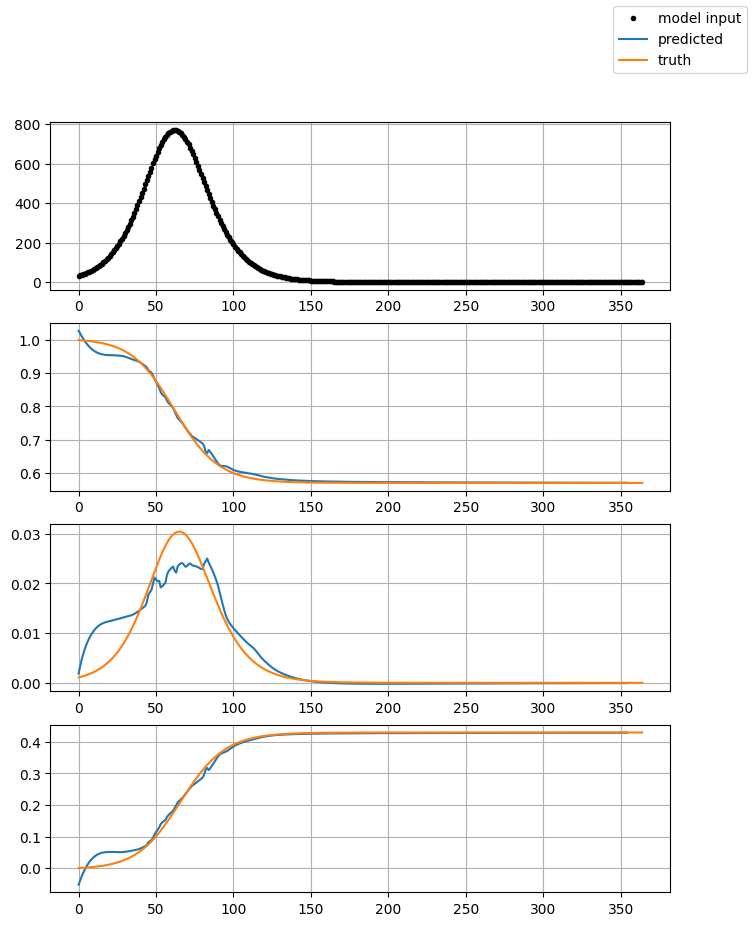

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, figsize=(8,10))

ax[0].plot(valset.i, '.', label='model input', color='black')
ax[0].grid()

ax[1].plot(output_array[:,0], label='predicted')
ax[1].plot(valset.states.S, label='truth')
fig.legend()
ax[1].grid()

ax[2].plot(output_array[:,1])
ax[2].plot(valset.states.I)
ax[2].grid()

ax[3].plot(output_array[:,2])
ax[3].plot(valset.states.R)
ax[3].grid()



Text(0.5, 1.0, '$R_0$')

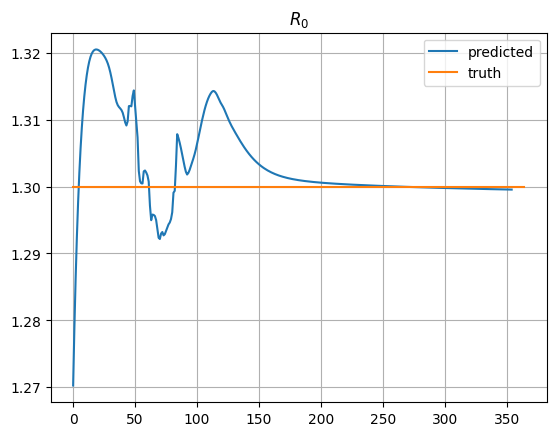

In [50]:
fig, ax = plt.subplots()

ax.plot(output_array[:,3], label='predicted')
ax.plot(valset.states.rt, label='truth')
ax.grid()
ax.legend()
ax.set_title(r'$R_0$')

In [45]:
log_A = model.s4_layers[0].kernel.log_A_real.to('cpu').detach().numpy()

In [49]:
np.exp(log_A)

array([[0.47179973, 0.51969665, 0.45088813, 0.52070415, 0.4917368 ,
        0.49968433, 0.48215124, 0.4867704 , 0.45466208, 0.47327483,
        0.47016954, 0.47533348, 0.46553564, 0.47157076, 0.51281554,
        0.5155533 , 0.4860432 , 0.46834788, 0.47279721, 0.51573724,
        0.5197466 , 0.50570273, 0.47958812, 0.44425094, 0.47809508,
        0.49190733, 0.47816396, 0.47836754, 0.4475326 , 0.51766115,
        0.47830158, 0.52495635],
       [0.508508  , 0.50726604, 0.5112724 , 0.50781274, 0.5072006 ,
        0.5076336 , 0.5105642 , 0.5069563 , 0.50932634, 0.49892908,
        0.50975424, 0.4959285 , 0.49543157, 0.4956165 , 0.49459085,
        0.5076353 , 0.5068917 , 0.49937472, 0.4957116 , 0.49409467,
        0.5061666 , 0.49704635, 0.5114046 , 0.49840152, 0.50758904,
        0.4956581 , 0.49538913, 0.50766444, 0.50612974, 0.506918  ,
        0.49487686, 0.507395  ],
       [0.5435322 , 0.49832836, 0.5477381 , 0.49427786, 0.4966723 ,
        0.49610257, 0.4965732 , 0.49090052, 0.5091